In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer

In [104]:

df = pd.read_csv(
    'C:/Users/Lenovo/Desktop/Autism_Data.arff', 
    na_values='?',
)

data = df.copy()

In [105]:
data.shape

(704, 21)

In [106]:
data.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,'United States',no,6,'18 and more',Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5,'18 and more',Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8,'18 and more',Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,'United States',no,6,'18 and more',Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,NaN,no,no,Egypt,no,2,'18 and more',NaN,NO


In [107]:
data.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,702.000000,704.000000
mean,0.721591,0.453125,0.457386,0.495739,0.498580,0.284091,0.417614,0.649148,0.323864,0.573864,29.698006,4.875000
std,0.448535,0.498152,0.498535,0.500337,0.500353,0.451301,0.493516,0.477576,0.468281,0.494866,16.507465,2.501493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,3.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,27.000000,4.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,7.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,383.000000,10.000000


In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 21 columns):
A1_Score           704 non-null int64
A2_Score           704 non-null int64
A3_Score           704 non-null int64
A4_Score           704 non-null int64
A5_Score           704 non-null int64
A6_Score           704 non-null int64
A7_Score           704 non-null int64
A8_Score           704 non-null int64
A9_Score           704 non-null int64
A10_Score          704 non-null int64
age                702 non-null float64
gender             704 non-null object
ethnicity          609 non-null object
jundice            704 non-null object
austim             704 non-null object
contry_of_res      704 non-null object
used_app_before    704 non-null object
result             704 non-null int64
age_desc           704 non-null object
relation           609 non-null object
Class/ASD          704 non-null object
dtypes: float64(1), int64(11), object(9)
memory usage: 115.6+ KB


In [109]:
data.dtypes.value_counts()

int64      11
object      9
float64     1
dtype: int64

In [110]:
total_missing_data = data.isnull().sum().sort_values(ascending=False)

percent_of_missing_data = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)

missing_data = pd.concat(
    [
        total_missing_data, 
        percent_of_missing_data
    ], 
    axis=1, 
    keys=['Total', 'Percent']
)

missing_data.head()

,Total,Percent
ethnicity,95,13.494318
relation,95,13.494318
age,2,0.284091
A9_Score,0,0.000000
A2_Score,0,0.000000


In [111]:
#result column
data.iloc[:, 0:10].sum(axis=1).head(10)

0    6
1    5
2    8
3    6
4    2
5    9
6    2
7    5
8    6
9    8
dtype: int64

In [112]:
#YES-NO into 0-1
data.columns = map(lambda x: x.strip().lower(), data.columns)
data.rename(columns={'class/asd': 'decision_class'}, inplace=True)
data.jundice = data.jundice.apply(lambda x: 0 if x == 'no' else 1)
data.austim = data.austim.apply(lambda x: 0 if x == 'no' else 1)
data.used_app_before = data.used_app_before.apply(lambda x: 0 if x == 'no' else 1)
data.decision_class = data.decision_class.apply(lambda x: 0 if x == 'NO' else 1)

In [113]:
#GENDER M-F to 0-1
le = LabelEncoder()

data.gender = le.fit_transform(data.gender) 

In [114]:
#STRING VALUES CLEANING
data.contry_of_res = data.contry_of_res.astype('str')
data.contry_of_res = data.contry_of_res.str.lower()
data.contry_of_res = data.contry_of_res.str.replace("'", "")
data.contry_of_res = data.contry_of_res.str.strip()

In [115]:
data.relation = data.relation.replace(np.nan, 'unknown', regex=True)
data.relation = data.relation.astype('str')
data.relation = data.relation.str.lower()
data.relation = data.relation.str.replace("'", "")
data.relation = data.relation.str.strip()

In [116]:
data.ethnicity = data.ethnicity.replace(np.nan, 'unknown', regex=True)
data.ethnicity = data.ethnicity.astype('str')
data.ethnicity = data.ethnicity.str.lower()
data.ethnicity = data.ethnicity.str.replace("'", "")
data.ethnicity = data.ethnicity.str.strip()

In [117]:
#GENDER VS DECISION CLASS
data.gender[data.decision_class == 0].value_counts() # 0-female, 1-male

1    281
0    234
Name: gender, dtype: int64

In [118]:
data.gender[data.decision_class == 1].value_counts() # 0-female, 1-male

0    103
1     86
Name: gender, dtype: int64

In [119]:
#ASD is diagnosed more commonly in females than males

In [120]:
#ETHNICITY VS DECISION CLASS
data.ethnicity[data.decision_class == 0].value_counts()

white-european    124
asian             107
unknown            86
middle eastern     84
south asian        33
black              25
others             22
pasifika           11
latino             10
hispanic            8
turkish             5
Name: ethnicity, dtype: int64

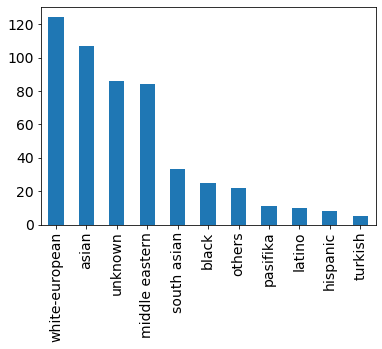

In [121]:
data.ethnicity[data.decision_class == 0].value_counts().plot(kind='bar')

In [122]:
data.ethnicity[data.decision_class == 1].value_counts()

white-european    109
black              18
asian              16
latino             10
others              9
unknown             9
middle eastern      8
hispanic            5
south asian         3
pasifika            1
turkish             1
Name: ethnicity, dtype: int64

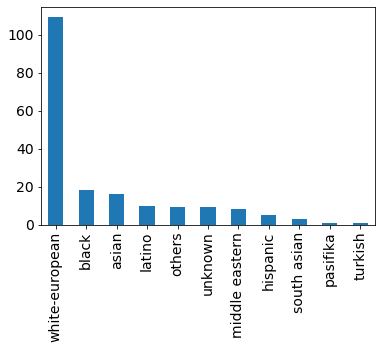

In [123]:
data.ethnicity[data.decision_class == 1].value_counts().plot(kind='bar')

In [124]:
#RELATION (WHO DID TEST) VS DECISION CLASS
data.relation[data.decision_class == 0].value_counts()

self                        365
unknown                      86
parent                       38
relative                     19
others                        4
health care professional      3
Name: relation, dtype: int64

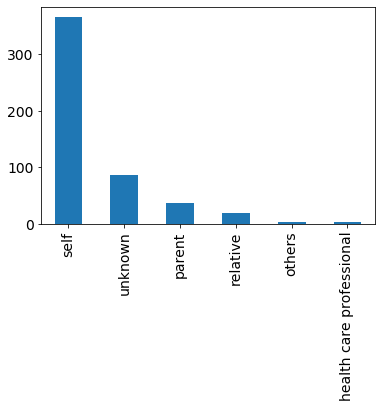

In [125]:
data.relation[data.decision_class == 0].value_counts().plot(kind='bar')

In [126]:
data.relation[data.decision_class == 1].value_counts()

self                        157
parent                       12
relative                      9
unknown                       9
others                        1
health care professional      1
Name: relation, dtype: int64

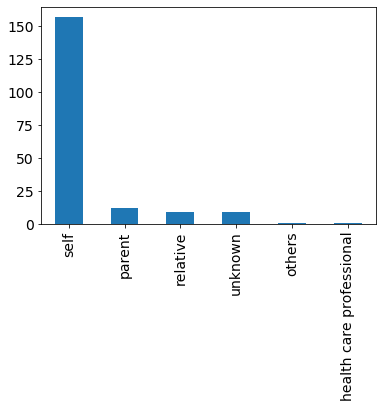

In [127]:
data.relation[data.decision_class == 1].value_counts().plot(kind='bar')

In [128]:
data.contry_of_res[data.decision_class == 0].value_counts().head(10)

united arab emirates    79
india                   75
new zealand             66
united states           60
united kingdom          48
jordan                  45
australia               15
sri lanka               14
afghanistan             11
iran                     7
Name: contry_of_res, dtype: int64

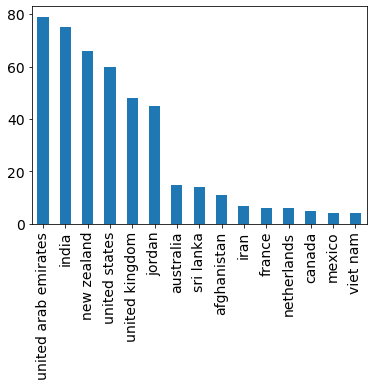

In [129]:
data.contry_of_res[data.decision_class == 0].value_counts().head(15).plot(kind='bar')

In [130]:
data.contry_of_res[data.decision_class == 1].value_counts().head(10)

united states     53
united kingdom    29
new zealand       15
australia         12
canada            10
india              6
france             5
brazil             5
netherlands        4
mexico             4
Name: contry_of_res, dtype: int64

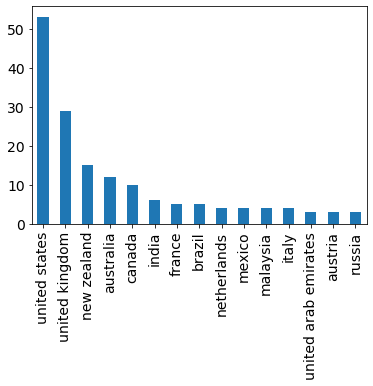

In [131]:
data.contry_of_res[data.decision_class == 1].value_counts().head(15).plot(kind='bar')

In [132]:
#LABEL BINARIZING
#for contry_of_res
lb = LabelBinarizer()

lb.fit(data.contry_of_res.values)

binarized_data = lb.transform(data.contry_of_res.values)

binarized_contry_of_res_matrix_data = np.vstack(binarized_data)
binarized_contry_of_res_matrix_data.shape

(704, 67)

In [133]:
#for relation
lb = LabelBinarizer()

lb.fit(data.relation.values)

binarized_data = lb.transform(data.relation.values)

binarized_result_matrix_data = np.vstack(binarized_data)
binarized_result_matrix_data.shape

(704, 6)

In [134]:
#for ethnicity
lb = LabelBinarizer()

lb.fit(data.ethnicity.values)

binarized_data = lb.transform(data.ethnicity.values)

binarized_ethnicity_matrix_data = np.vstack(binarized_data)
binarized_ethnicity_matrix_data.shape

(704, 11)

In [135]:
data.drop(['age_desc', 'result'], axis=1, inplace=True)

In [136]:
data.head()

,a1_score,a2_score,a3_score,a4_score,a5_score,a6_score,a7_score,a8_score,a9_score,a10_score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,relation,decision_class
0,1,1,1,1,0,0,1,1,0,0,26.0,0,white-european,0,0,united states,0,self,0
1,1,1,0,1,0,0,0,1,0,1,24.0,1,latino,0,1,brazil,0,self,0
2,1,1,0,1,1,0,1,1,1,1,27.0,1,latino,1,1,spain,0,parent,1
3,1,1,0,1,0,0,1,1,0,1,35.0,0,white-european,0,1,united states,0,self,0
4,1,0,0,0,0,0,0,1,0,0,40.0,0,unknown,0,0,egypt,0,unknown,0


In [137]:
data.age.max(),data.age.min()

(383.0, 17.0)

In [138]:
data.age.median()

27.0

In [139]:
data.age.replace(data.age.max(), data.age.median(), inplace=True)

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


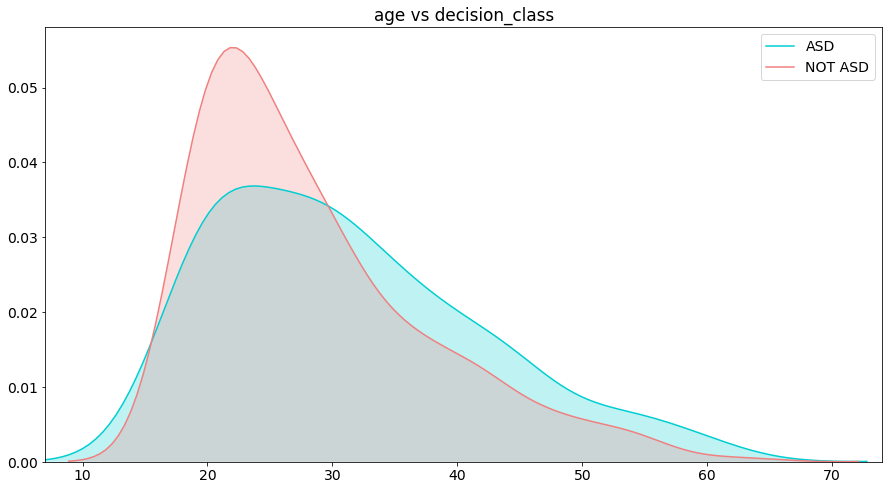

In [140]:
plt.figure(figsize=(15,8))

sns.kdeplot(
    data.age[data.decision_class == 1], 
    color="darkturquoise", 
    shade=True
)

sns.kdeplot(
    data.age[data.decision_class == 0], 
    color="lightcoral", 
    shade=True
)

plt.legend(['ASD', 'NOT ASD'])
plt.title('age vs decision_class')
plt.xlim(data.age.min() - 10, data.age.max() + 10)
plt.show()

In [141]:
data.decision_class.value_counts()

0    515
1    189
Name: decision_class, dtype: int64

In [142]:
data.gender[data.decision_class == 1].value_counts()

0    103
1     86
Name: gender, dtype: int64

In [143]:
data.gender[data.decision_class == 0].value_counts()

1    281
0    234
Name: gender, dtype: int64

In [144]:
data.isnull().sum()

a1_score           0
a2_score           0
a3_score           0
a4_score           0
a5_score           0
a6_score           0
a7_score           0
a8_score           0
a9_score           0
a10_score          0
age                2
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
relation           0
decision_class     0
dtype: int64

In [145]:
#MISSING VALUES IMPUTATION
to_update_nans_dict = {}

columns = [
    'age'
]

for _decision_class in [0, 1]:
    for column in columns:
        vals = data[data.decision_class == _decision_class][column].value_counts()
        
        to_update_nans_dict['{decision_class}_{column}'.format(
            decision_class=_decision_class,
            column=column
        )] = vals.idxmax()

In [146]:
to_update_nans_dict

{'0_age': 21.0, '1_age': 30.0}

In [147]:
data.iloc[62, data.columns.get_loc('age')] = to_update_nans_dict.get('0_age')

In [148]:
data.iloc[91, data.columns.get_loc('age')] = to_update_nans_dict.get('1_age')

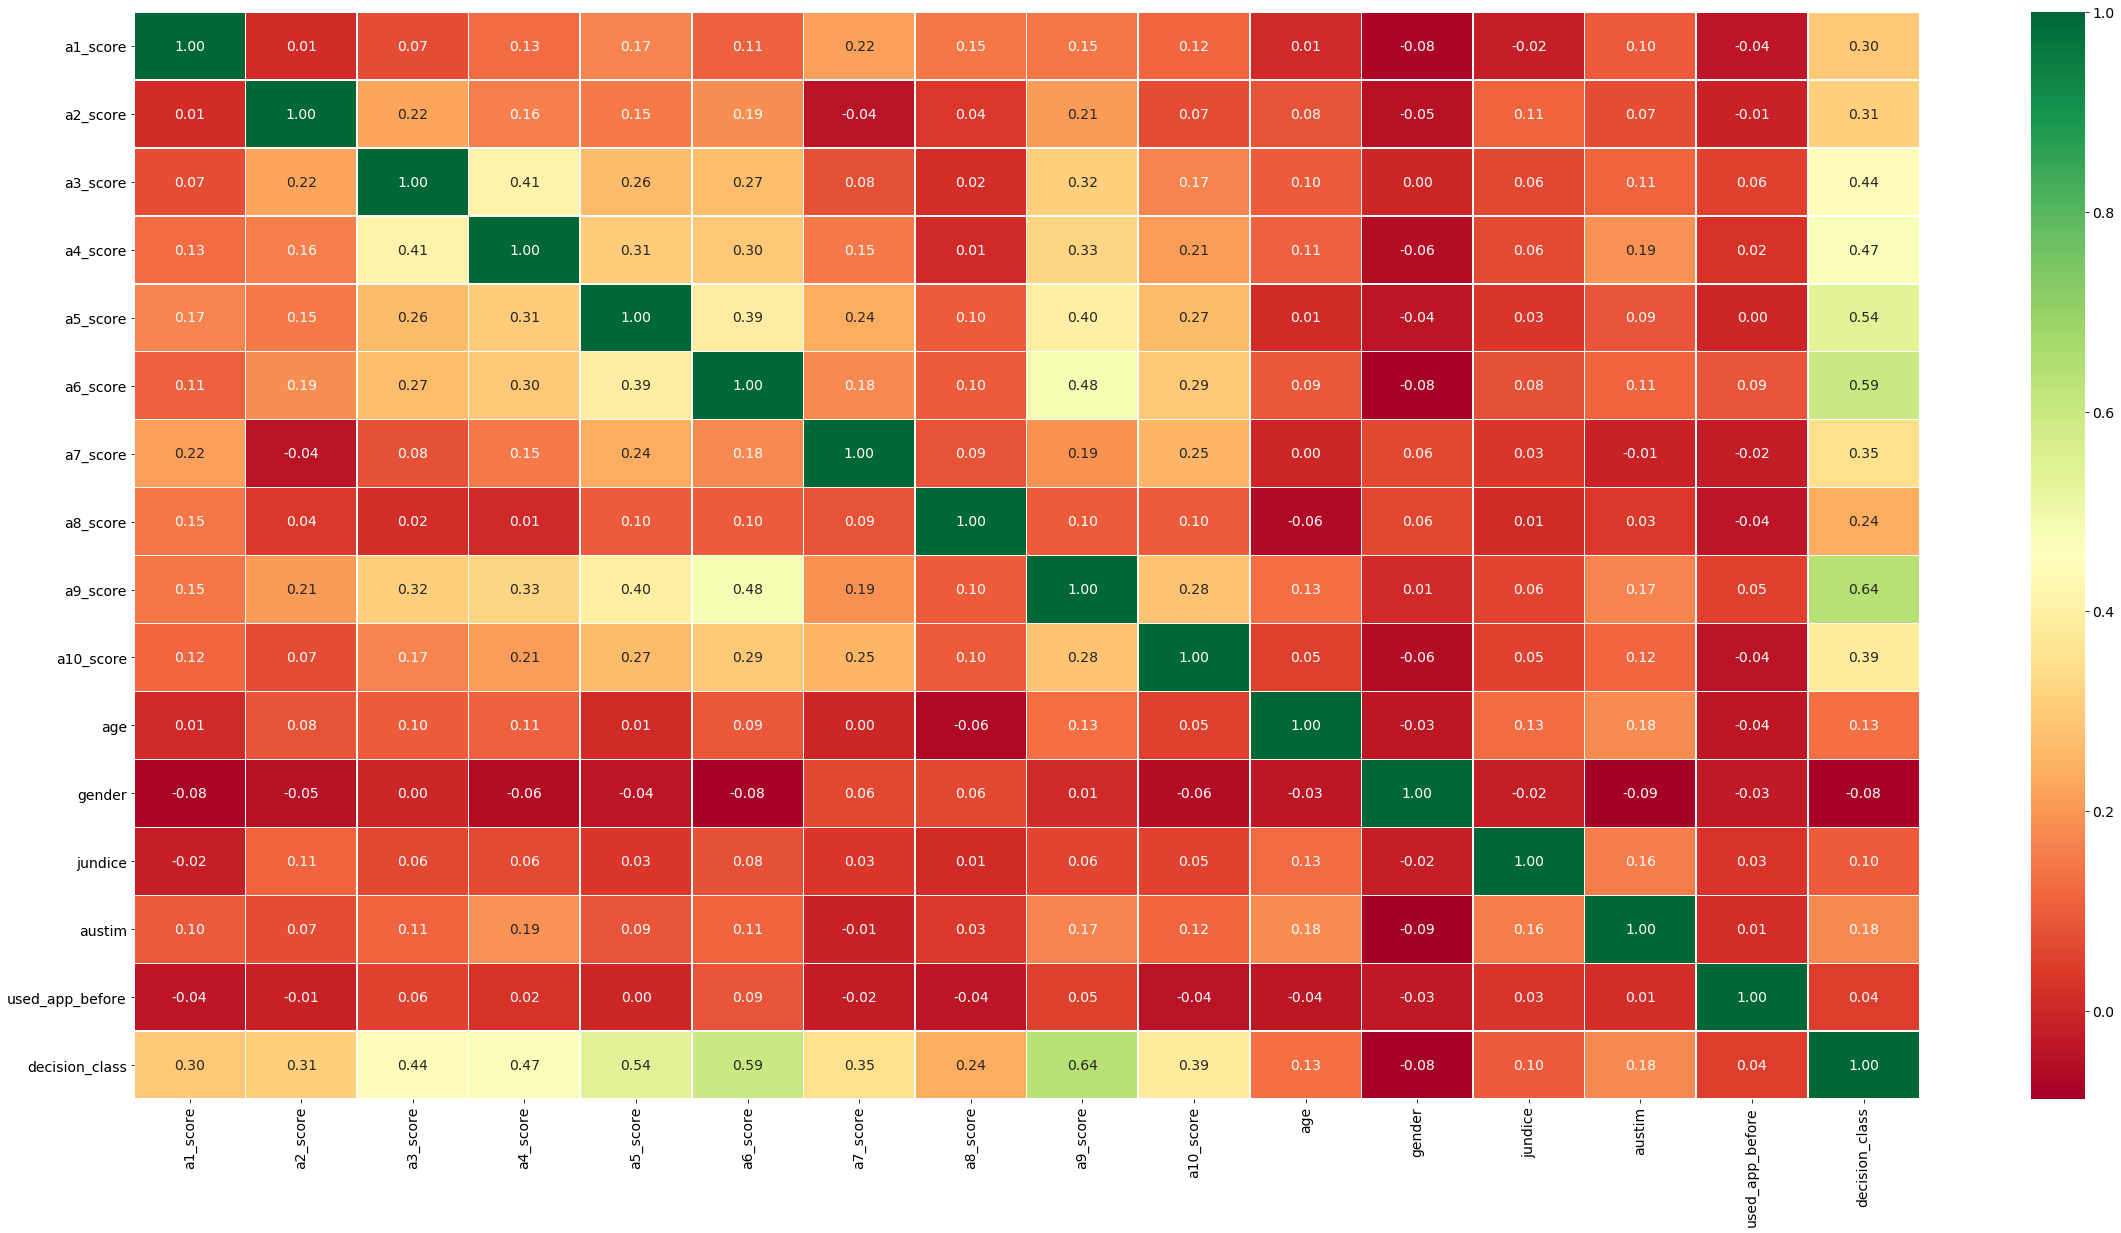

In [149]:
#HEATMAP
corr = data.corr()

sns.heatmap(
    data=corr,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cmap='RdYlGn',
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)

fig = plt.gcf()
fig.set_size_inches(40, 20)

plt.show()


In [150]:
#PREPARING DATA FOR MODEL
feature_names = list(
    set(data.columns[0:-1].tolist()).difference(['contry_of_res', 'relation', 'ethnicity'])
)

X = data[feature_names].as_matrix()

X_new = np.hstack((
    X, 
    binarized_contry_of_res_matrix_data,
    binarized_ethnicity_matrix_data,
    binarized_result_matrix_data,
))
                   
y = data.decision_class

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [151]:
X_new.shape, y.shape

((704, 99), (704,))

In [152]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new,
    y,
    random_state=42,
    test_size=0.3
)

In [153]:
log_reg = LogisticRegression(
    C=1,
    penalty='l1',
    solver='liblinear',
    random_state=42,
    multi_class='ovr'

)

In [154]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [155]:
log_reg_predict = log_reg.predict(X_test)

In [156]:
log_reg.score(X_test, y_test)

1.0

In [157]:
preds = log_reg.predict(X_test)

In [158]:
log_reg_predict_proba = log_reg.predict_proba(X_test)[:, 1]

In [159]:
print('\nLogistic Regression Accuracy: {:.2f}%'.format(accuracy_score(y_test, log_reg_predict) * 100))
print('Logistic Regression AUC: {:.2f}%'.format(roc_auc_score(y_test, log_reg_predict) * 100))
print('Logistic Regression Classification report:\n\n', classification_report(y_test, log_reg_predict))


Logistic Regression Accuracy: 100.00%
Logistic Regression AUC: 100.00%
Logistic Regression Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       155
           1       1.00      1.00      1.00        57

    accuracy                           1.00       212
   macro avg       1.00      1.00      1.00       212
weighted avg       1.00      1.00      1.00       212



In [160]:
print(confusion_matrix(y_test, preds))

[[155   0]
 [  0  57]]


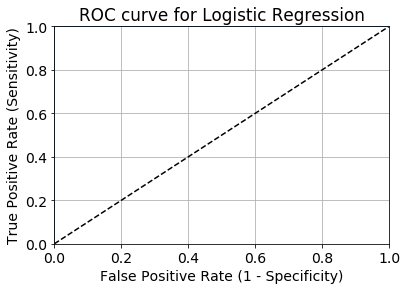

In [161]:
#ROC FOR LOGISTIC REGRESSION
fpr, tpr, thresholds = roc_curve(
    y_test, 
    log_reg_predict_proba
)

plt.plot(
    [0, 1], 
    [0, 1], 
    'k--'
)

plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.rcParams['font.size'] = 14

plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.grid(True)

In [162]:
#F1 SCORE AFTER 10-FOLD CROSS-VALIDATION
kfold = StratifiedKFold(
    n_splits=10, 
    shuffle=True, 
    random_state=42
)

predicted = cross_val_predict(
    log_reg, 
    X_new, 
    y, 
    cv=kfold
)

scores = cross_val_score(
    log_reg, 
    X_new, 
    y, 
    cv=kfold,
    scoring='f1'
)

print('Cross-validated scores: {}\n'.format(scores))

print(classification_report(y, predicted))

print("\nLogisticRegression: F1 after 10-fold cross-validation: {:.2f}% (+/- {:.2f}%)".format(
    scores.mean() * 100,
    scores.std() * 2
))

Cross-validated scores: [1.         1.         1.         1.         0.97297297 1.
 1.         1.         1.         0.97142857]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       515
           1       1.00      0.99      0.99       189

    accuracy                           1.00       704
   macro avg       1.00      0.99      1.00       704
weighted avg       1.00      1.00      1.00       704


LogisticRegression: F1 after 10-fold cross-validation: 99.44% (+/- 0.02%)


In [163]:
#Cross-validation minimizes classification error estimation bias and is thus primarily used for small sample datasets.
#As expected, the classification f1 score dropped 
#from ∼100% for the full dataset to ∼99.75% with 10-fold or percentage-split cross-validation.